### load google drive


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Install mtcnn library
!pip install mtcnn
!pip install lz4
!pip install --upgrade joblib lz4


# Import necessary libraries
import os
import cv2  # Untuk pengolahan citra dan deteksi wajah
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from sklearn.decomposition import PCA
from mtcnn import MTCNN # Import the MTCNN module after installation
detector = MTCNN()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.0 MB/s eta 0:00:00


In [3]:
# Load dan proses citra contoh untuk perbandingan
example_image_path = '/content/drive/MyDrive/Computer Vision/face_recognition/train/man/S429-04-t10_01.png'  # Mengganti dengan path citra Anda
original_image = cv2.imread(example_image_path)

In [4]:
# Fungsi untuk pengolahan citra (misal: konversi ke grayscale dan equalization)
def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Konversi ke grayscale
    equalized = cv2.equalizeHist(gray)  # Histogram equalization
    return equalized

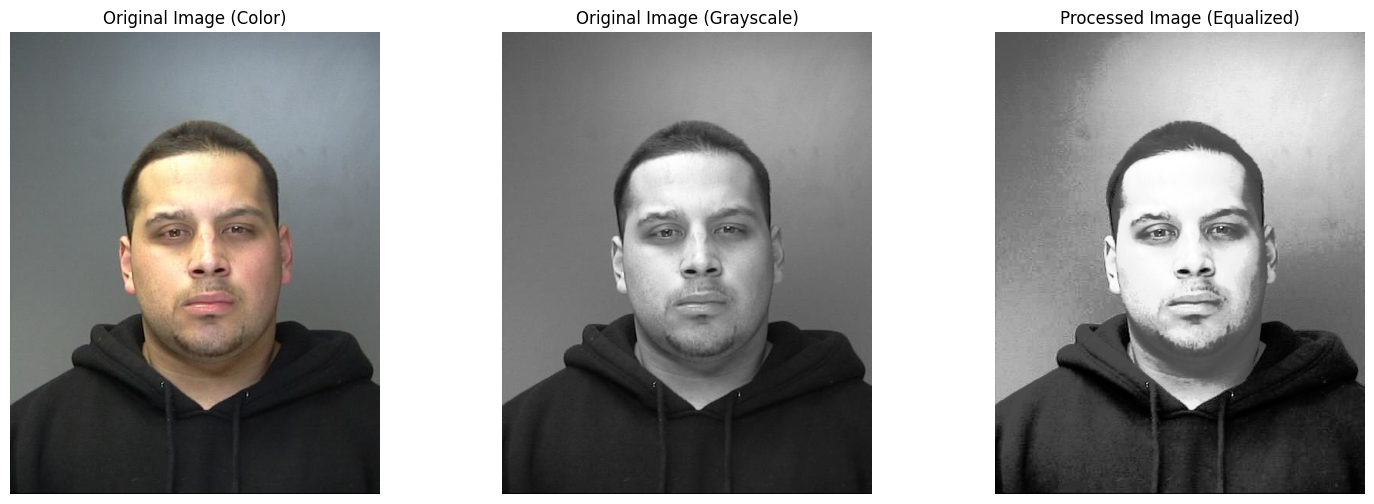

In [5]:
# Fungsi untuk menampilkan perbandingan citra (original vs grayscale vs equalized)
def display_images(original, grayscale, equalized):
    plt.figure(figsize=(18, 6))

    # Menampilkan citra asli berwarna
    plt.subplot(1, 3, 1)
    plt.title('Original Image (Color)')
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))  # Konversi BGR ke RGB untuk tampilan warna yang benar
    plt.axis('off')

    # Menampilkan citra asli dalam grayscale
    plt.subplot(1, 3, 2)
    plt.title('Original Image (Grayscale)')
    plt.imshow(grayscale, cmap='gray')
    plt.axis('off')

    # Menampilkan citra yang telah diproses (equalized)
    plt.subplot(1, 3, 3)
    plt.title('Processed Image (Equalized)')
    plt.imshow(equalized, cmap='gray')
    plt.axis('off')

    plt.show()

# Konversi citra asli ke grayscale
gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

# Lakukan histogram equalization pada citra grayscale
equalized_image = cv2.equalizeHist(gray_image)

# Tampilkan perbandingan antara citra asli, citra grayscale, dan citra equalized
display_images(original_image, gray_image, equalized_image)


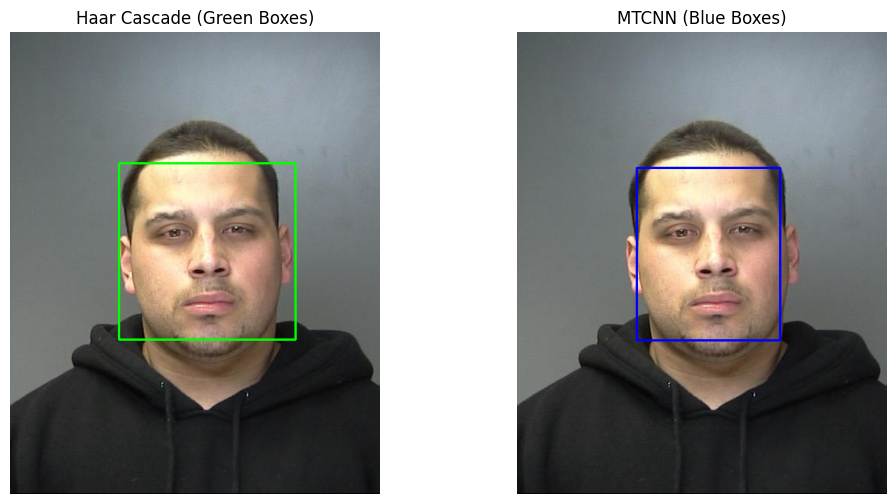

In [6]:

# Inisialisasi detektor wajah Haar Cascade dan MTCNN
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
detector = MTCNN()

# Fungsi untuk mendeteksi wajah menggunakan Haar Cascade atau MTCNN
def detect_faces(image, method='haar'):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    if method == 'haar':
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)
    elif method == 'mtcnn':
        results = detector.detect_faces(image)
        faces = [(res['box'][0], res['box'][1], res['box'][2], res['box'][3]) for res in results]
    return faces

# Fungsi untuk menampilkan citra dengan hasil deteksi wajah dan perbedaan warna kotak
def display_detected_faces_side_by_side(image, faces_haar, faces_mtcnn):
    # Salin citra untuk menghindari modifikasi langsung
    image_haar = image.copy()
    image_mtcnn = image.copy()

    # Gambar kotak di sekitar wajah yang terdeteksi oleh Haar Cascade
    for (x, y, w, h) in faces_haar:
        cv2.rectangle(image_haar, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Kotak Hijau untuk Haar

    # Gambar kotak di sekitar wajah yang terdeteksi oleh MTCNN
    for (x, y, w, h) in faces_mtcnn:
        cv2.rectangle(image_mtcnn, (x, y), (x + w, y + h), (255, 0, 0), 2)  # Kotak Merah untuk MTCNN

    # Konversi citra BGR ke RGB untuk tampil dengan benar di Matplotlib
    image_haar_rgb = cv2.cvtColor(image_haar, cv2.COLOR_BGR2RGB)
    image_mtcnn_rgb = cv2.cvtColor(image_mtcnn, cv2.COLOR_BGR2RGB)

    # Menampilkan citra secara bersebrangan
    plt.figure(figsize=(12, 6))

    # Menampilkan citra Haar Cascade
    plt.subplot(1, 2, 1)
    plt.imshow(image_haar_rgb)
    plt.axis('off')
    plt.title('Haar Cascade (Green Boxes)')

    # Menampilkan citra MTCNN
    plt.subplot(1, 2, 2)
    plt.imshow(image_mtcnn_rgb)
    plt.axis('off')
    plt.title('MTCNN (Blue Boxes)')

    plt.show()

# Load citra untuk deteksi
img_path = '/content/drive/MyDrive/Computer Vision/face_recognition/train/man/S429-04-t10_01.png'  # Ganti dengan path citra Anda
image = cv2.imread(img_path)

# Deteksi wajah menggunakan Haar Cascade dan MTCNN
faces_haar = detect_faces(image, method='haar')  # Deteksi menggunakan Haar Cascade
faces_mtcnn = detect_faces(image, method='mtcnn')  # Deteksi menggunakan MTCNN

# Tampilkan citra dengan wajah yang terdeteksi secara bersebrangan
display_detected_faces_side_by_side(image, faces_haar, faces_mtcnn)


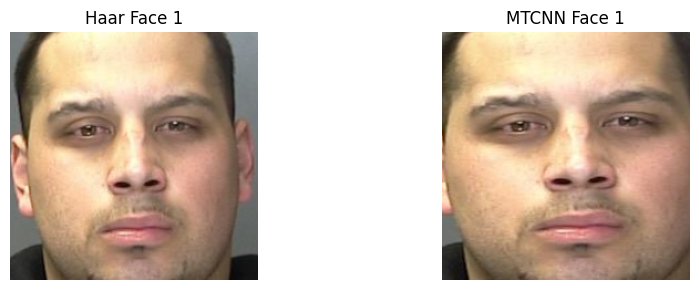

In [7]:
# Fungsi untuk crop wajah berdasarkan koordinat deteksi
def crop_faces(image, faces):
    cropped_faces = []
    for (x, y, w, h) in faces:
        face = image[y:y+h, x:x+w]
        face = cv2.resize(face, (224, 224))  # Resize ke ukuran yang sesuai
        cropped_faces.append(face)
    return cropped_faces

# Crop wajah dari hasil deteksi Haar dan MTCNN
cropped_faces_haar = crop_faces(original_image, faces_haar)
cropped_faces_mtcnn = crop_faces(original_image, faces_mtcnn)

# Tentukan jumlah wajah yang akan ditampilkan di grid
num_faces = max(len(cropped_faces_haar), len(cropped_faces_mtcnn))

# Plot hasil cropping wajah untuk Haar dan MTCNN dalam format kiri-kanan
plt.figure(figsize=(10, num_faces * 3))

for i in range(num_faces):
    # Tampilkan wajah hasil cropping dari Haar di kolom kiri
    if i < len(cropped_faces_haar):
        plt.subplot(num_faces, 2, 2 * i + 1)
        plt.imshow(cv2.cvtColor(cropped_faces_haar[i], cv2.COLOR_BGR2RGB))
        plt.title(f'Haar Face {i + 1}')
        plt.axis('off')

    # Tampilkan wajah hasil cropping dari MTCNN di kolom kanan
    if i < len(cropped_faces_mtcnn):
        plt.subplot(num_faces, 2, 2 * i + 2)
        plt.imshow(cv2.cvtColor(cropped_faces_mtcnn[i], cv2.COLOR_BGR2RGB))
        plt.title(f'MTCNN Face {i + 1}')
        plt.axis('off')

plt.tight_layout()
plt.show()


In [8]:
# Ekstraksi fitur dan klasifikasi menggunakan VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [9]:
# Data dan parameter untuk pelatihan
train_data_dir = r'/content/drive/MyDrive/Computer Vision/face_recognition/train'
validation_data_dir = r'/content/drive/MyDrive/Computer Vision/face_recognition/val'
image_size = (224, 224)
batch_size = 32

In [10]:
# Data Augmentation dan Normalisasi
datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [11]:
# Data Generator untuk Training dan Validation
train_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

validation_generator = datagen.flow_from_directory(
    validation_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

Found 405 images belonging to 2 classes.
Found 564 images belonging to 2 classes.


In [12]:
# Membuat model VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(train_generator.num_classes, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Melatih model
epochs = 10
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 7/13 ━━━━━━━━━━━━━━━━━━━━ 1:55 19s/step - accuracy: 0.7446 - loss: 0.4851

In [ ]:
# Plot History
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

In [ ]:
# Simpan Model
model.save('face_recognition_with_vggnet.keras')

# Plot the history
plot_history(history)

In [ ]:
# Evaluasi model
y_true = validation_generator.classes
y_pred = np.argmax(model.predict(validation_generator), axis=-1)
print(classification_report(y_true, y_pred))

In [ ]:
# Hitung akurasi
accuracy = np.sum(y_true == y_pred) / len(y_true) * 100
print(f'Accuracy: {accuracy:.2f}%')

In [ ]:
# Analisis hasil klasifikasi
success_count = np.sum(y_true == y_pred)
failure_count = np.sum(y_true != y_pred)
print(f'Jumlah wajah berhasil diklasifikasikan: {success_count}')
print(f'Jumlah wajah tidak berhasil diklasifikasikan: {failure_count}')


In [ ]:
# Melakukan prediksi pada data gambar asli menggunakan model CNN
y_pred = model.predict(validation_generator, steps=len(validation_generator))
y_pred_classes = np.argmax(y_pred, axis=1)

# Mendapatkan label asli dari validation_generator
y_true = validation_generator.classes

In [ ]:
# Mendapatkan indeks dari data yang tidak berhasil diklasifikasikan
misclassified_indices = np.where(y_pred_classes != y_true)[0]
correctly_classified_indices = np.where(y_pred_classes == y_true)[0]

print(f"Jumlah wajah yang berhasil diklasifikasikan: {len(correctly_classified_indices)}")
print(f"Jumlah wajah yang tidak berhasil diklasifikasikan: {len(misclassified_indices)}")


In [ ]:
# Mengatur jumlah gambar yang akan ditampilkan (maksimal 40)
num_misclassified_to_show = min(40, len(misclassified_indices))

plt.figure(figsize=(20, 40))  # Sesuaikan ukuran gambar untuk menampung 40 gambar
for i, idx in enumerate(misclassified_indices[:num_misclassified_to_show]):
    # Mengambil batch dan indeks gambar dari generator
    batch_idx = idx // batch_size
    within_batch_idx = idx % batch_size

    # Pastikan untuk mengambil gambar dari validation_generator
    img, label = validation_generator[batch_idx]

    # Menampilkan gambar
    plt.subplot(10, 4, i + 1)  # Ubah layout menjadi 10 baris dan 4 kolom
    plt.imshow(img[within_batch_idx])
    plt.axis('off')

    # Tampilkan label asli dan prediksi yang salah
    plt.title(f"Label Asli: {y_true[idx]}, Prediksi: {y_pred_classes[idx]}")

plt.suptitle("Contoh Gambar yang Tidak Berhasil Diklasifikasikan")
plt.show()


In [ ]:
# Mengatur jumlah gambar yang akan ditampilkan (maksimal 50)
num_correct_to_show = min(50, len(correctly_classified_indices))

plt.figure(figsize=(20, 50))  # Sesuaikan ukuran figure untuk menampung 50 gambar
for i, idx in enumerate(correctly_classified_indices[:num_correct_to_show]):
    # Mengambil batch dan indeks gambar dari generator
    batch_idx = idx // batch_size
    within_batch_idx = idx % batch_size

    # Pastikan untuk mengambil gambar dari validation_generator
    img, label = validation_generator[batch_idx]

    # Menampilkan gambar
    plt.subplot(10, 5, i + 1)  # Ubah layout menjadi 10 baris dan 5 kolom
    plt.imshow(img[within_batch_idx])
    plt.axis('off')

    # Tampilkan label asli dan prediksi yang benar
    plt.title(f"Label Asli: {y_true[idx]}, Prediksi: {y_pred_classes[idx]}")

plt.suptitle("Contoh Gambar yang Berhasil Diklasifikasikan")
plt.show()
